## Name : Shubham Agrawal
## Roll No: 2019201085

## Question 1 - Face Detection (Viola Jones)

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, string , sys, time, re
from tqdm import tqdm

In [ ]:
%cd drive/MyDrive/CV-A4/natural_images
# !ls drive/MyDrive/CV-A4/natural_images/person/
!ls person | wc 

## crop the faces in the fddb
## Extract Features
## for all images
## Run ada boost
## find Accuracy
## detect face

/content/drive/MyDrive/CV-A4/natural_images
    986     986   15776


In [ ]:
# %cd drive/MyDrive/CV-A4/natural_images
# !ls
# !ls person | wc 
# !ls car | wc 
# !ls cat | wc 
# !ls dog | wc 
# !ls flower | wc 
# !ls fruit | wc 
# !ls motorbike | wc 
# !ls airplane | wc 
# paths = ['car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'airplane']
# import shutil
# for p in tqdm(paths):
#   files = os.listdir(p)
#   for file in files[:140]:
#     file_name = p + '/' + file
#     # print(file_name)
#     shutil.copy(file_name, "non_faces")
!ls non_faces | wc

    980     980   14980


### Load Images in 24*24

In [ ]:
def load_image(img_path):
  image = cv2.imread(img_path.strip())
  image = cv2.resize(image,(24, 24))
  return image

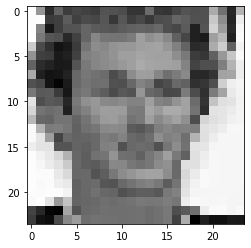

In [ ]:
img = load_image('person/person_0008.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = img/255
plt.imshow(img, cmap='gray')

### Function to calculate the integral image

In [ ]:
def get_integral_image(img):
  integral = img.copy().astype('int32')
  # integral = np.array([[1, 1, 1, 1],[1, 1, 1, 1],[1, 1, 1, 1], [1, 1, 1, 1]])
  # img.cumsum().reshape(24, 24)
  for i in range(0, integral.shape[0]):
    for j in range(0, integral.shape[1]):
      if (i==0 and j==0):
        integral[i][j] = integral[i][j]
      elif (i==0):
        integral[i][j] = integral[i][j] + integral[i][j-1]
      elif (j==0):
        integral[i][j] = integral[i][j] + integral[i-1][j]
      else:
        integral[i][j] = integral[i][j] + integral[i-1][j] + integral[i][j-1] - integral[i-1][j-1]
  return integral

### Function to calulate area of rectangle from integral image in O(1) time

In [ ]:
def get_rect_area(integral, x, y, h, w):
  x2 = x + h - 1
  y2 = y + w - 1 
  if(x==0 and y==0):
    return integral[x2][y2]

  if(x==0):
    return integral[x2][y2] - integral[x2][y-1]

  if(y==0):
    return integral[x2][y2] - integral[x-1][y2]
  
  x1 = x - 1
  y1 = y - 1
  return integral[x2][y2] - integral[x1][y2] - integral[x2][y1] + integral[x1][y1] 

# intg = get_integral_image(np.array([[1, 1, 1, 1, 1],[1, 1, 1, 1, 1],[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]))
# print(intg)
# print(get_rect_area(intg, 0, 0, 4, 2))

### function to compute the haar score for this 5 features. 

In [ ]:
features = [[2, 1], [1, 2], [3, 1], [1, 3], [2, 2]]  #[[h, w]]

In [ ]:
# edge feature horizontal
def feature12(integral_image, x, y, h, w):
  region1 = get_rect_area(integral_image, x, y, h//2, w)
  region2 = get_rect_area(integral_image, x+h//2, y, h//2, w)
  return np.abs(region1 - region2)

# edge feature vertical
def feature21(integral_image, x, y, h, w):
  region1 = get_rect_area(integral_image, x, y, h, w//2)
  region2 = get_rect_area(integral_image, x, y+w//2, h, w//2)
  return np.abs(region1 - region2)

# line feature horizontal
def feature13(integral_image, x, y, h, w):
  h3=h//3
  region1 = get_rect_area(integral_image, x, y, h3, w)
  region2 = get_rect_area(integral_image, x+h3, y, h3, w)
  region3 = get_rect_area(integral_image, x+2*h3, y, h3, w)
  return np.abs(region1 + region3 - region2)

# edge feature vertical
def feature31(integral_image, x, y, h, w):
  w3=w//3
  region1 = get_rect_area(integral_image, x, y, h, w3)
  region2 = get_rect_area(integral_image, x, y+w3, h, w3)
  region3 = get_rect_area(integral_image, x, y+2*w3, h, w3)
  return np.abs(region1 + region3 - region2)


# diagonal feature
def feature22(integral_image, x, y, h, w):
  w2=w//2
  h2=h//2
  region1 = get_rect_area(integral_image, x, y, h2, w2)
  region2 = get_rect_area(integral_image, x, y+w2, h2, w2)
  region3 = get_rect_area(integral_image, x+h2, y, h2, w2)
  region4 = get_rect_area(integral_image, x+h2, y+w2, h2, w2)
  return np.abs(region1 + region4 - region2 - region3)

### Count number of features in 24x24 image

In [ ]:
c=0
window = 24
for f in features:
    sx = f[0]
    sy = f[1]
    for x in range(window-sx+1):
      for y in range(window-sy+1):
        for w in range(sx, window-x+1, sx):
          for h in range(sy, window-y+1, sy):
            c+=1
print(c)

162336


### Calculate 160k features for one image

In [ ]:
integral_image = get_integral_image(img)
window = 24
img_features = []
for i, f in enumerate(features):
    sx = f[0]
    sy = f[1]
    for x in range(window-sx+1):
      for y in range(window-sy+1):
        for w in range(sy, window-y+1, sy):
          for h in range(sx, window-x+1, sx):
            # print(x, y, h, w)
            if(i==0):
              img_features.append(feature21(integral_image, x, y, h, w))
            if(i==1):
              img_features.append(feature12(integral_image, x, y, h, w))
            if(i==2):
              img_features.append(feature31(integral_image, x, y, h, w))
            if(i==3):
              img_features.append(feature13(integral_image, x, y, h, w))
            if(i==4):
              img_features.append(feature22(integral_image, x, y, h, w))

In [ ]:
len(img_features)

162336

### Calculate the features all the images

In [ ]:
# !ls person
images_path = []
files = os.listdir('person/')
for i in files[:500]:
  images_path.append("person/" + i)
print(len(images_path))

files = os.listdir('non_faces/')
for i in files[:500]:
  images_path.append("non_faces/" + i)
print(len(images_path))
# img = load_image('person/person_0008.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # img = img/255
# plt.imshow(img, cmap='gray')

500
1000


In [ ]:
data = []
for path in tqdm(images_path):
  img = load_image(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  integral_image = get_integral_image(img)
  window = 24
  img_features = []
  for i, f in enumerate(features):
      sx = f[0]
      sy = f[1]
      for x in range(window-sx+1):
        for y in range(window-sy+1):
          for w in range(sy, window-y+1, sy):
            for h in range(sx, window-x+1, sx):
              # print(x, y, h, w)
              if(i==0):
                img_features.append(feature21(integral_image, x, y, h, w))
              if(i==1):
                img_features.append(feature12(integral_image, x, y, h, w))
              if(i==2):
                img_features.append(feature31(integral_image, x, y, h, w))
              if(i==3):
                img_features.append(feature13(integral_image, x, y, h, w))
              if(i==4):
                img_features.append(feature22(integral_image, x, y, h, w))
  data.append(img_features)

100%|██████████| 1000/1000 [26:06<00:00,  1.57s/it]


### Ada Boost Algorithm

## Question 2 - Bag of Visual Words (BOVW)

In [15]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, string , sys, time, re
from tqdm import tqdm

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
%cd drive/MyDrive/CV-A4/SUN_data/
# !ls train/aquarium/ | wc -l

In [70]:
categories = [
                'highway',
                'aquarium',
                'desert',
                'park',
                'waterfall',
                'kitchen',
                'laundromat',
                'windmill'
            ]

def id_to_label(id):
  return categories[int(id)]

### Load Data

In [74]:
def load_image(img_path):
  image = cv2.imread(img_path.strip())
  image = cv2.resize(image,(150, 150))
  return image

def get_data(train_test, categories):
  data = []
  labels = []
  for i in range(len(categories)):
    path = train_test+'/'+categories[i]
    files = os.listdir(path)
    for f in tqdm(files):
      if(f[0] != '.'):
        img_path = path + "/" + f
        data.append(load_image(img_path))
        labels.append(i)
  return np.array(data), np.array(labels)

In [75]:
train_images, train_labels = get_data('train', categories)
test_images, test_labels = get_data('test', categories)
print('Done')
print(train_images.shape, test_images.shape)

100%|██████████| 21/21 [00:00<00:00, 169.83it/s]

Done
(640, 150, 150, 3) (160, 150, 150, 3)


### Get Dense Sift Descriptors using step = 5

In [76]:
def get_descriptors(img, step=5):
  r = img.shape[0]
  c = img.shape[1]
  kps = []
  for i in range(step, 150-step, step):
    for j in range(step, 150-step, step):
      kps.append(cv2.KeyPoint(float(j), float(i), float(step)))
  # print(len(kps))

  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.compute(img, kps)
  return descriptors

def get_all_descriptors(images, step):
  descriptors_list = []
  for image in tqdm(images):
    descriptors_list.extend(get_descriptors(image, step))
  return np.array(descriptors_list)

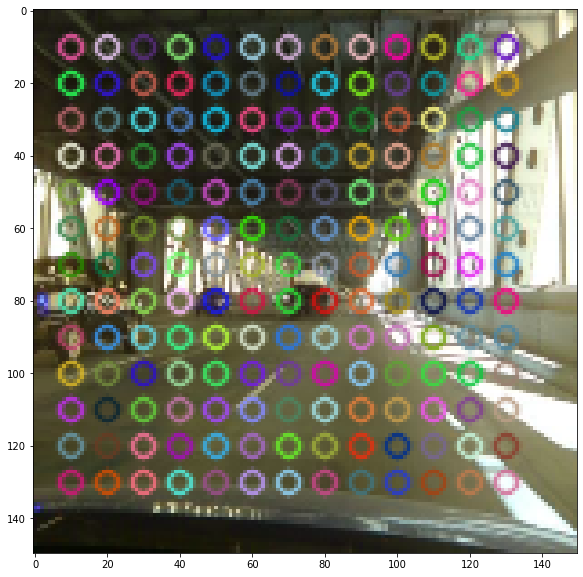

In [43]:
img = train_images[0]
r = img.shape[0]
c = img.shape[1]
kps = []
step=10
for i in range(step, 150-step, step):
  for j in range(step, 150-step, step):
    kps.append(cv2.KeyPoint(float(j), float(i), float(step)))
# print(len(kps))

sift = cv2.xfeatures2d.SIFT_create()
keypoints, descriptors = sift.compute(img, kps)
img1 = cv2.drawKeypoints(img,keypoints, outImage=None)
plt.figure(figsize=(10, 10))
plt.imshow(img1)

### Each image will have 784 dense sift descriptor for step_size = 5

### Each image will have 169 dense sift descriptor for step_size = 10

In [77]:
step_size = 5
des_size = len(get_descriptors(train_images[0], step_size))
des_size

784

In [78]:
train_descriptors = get_all_descriptors(train_images, step_size)
test_descriptors = get_all_descriptors(test_images, step_size)
print(train_descriptors.shape)
print(test_descriptors.shape)

100%|██████████| 160/160 [00:05<00:00, 28.39it/s]


(501760, 128)
(125440, 128)


### KMeans (here, I have used Sklearn Kmeans and MiniBatchKMeans (for large value of K))

In [79]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import timeit
K=100
start_time = timeit.default_timer()
# kmeans = KMeans(n_clusters=K, random_state=0).fit(train_descriptors)
kmeans = MiniBatchKMeans(init ='k-means++', n_clusters = K,
                      batch_size = 1000, init_size=K+1).fit(train_descriptors)

# print(len(kmeans.labels_))
stop_time = timeit.default_timer()
print("Time Taken(seconds) : ", stop_time - start_time)

Time Taken(seconds) :  19.041324454999994


In [80]:
print(len(kmeans.labels_))

501760


## Histogram


### Step_size = 5 and K = 500

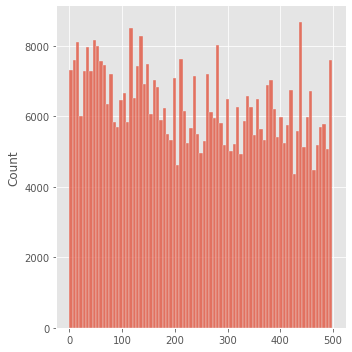

In [91]:
plt.style.use('ggplot')
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 10
sns.displot(kmeans.labels_)
plt.show()

### Step_size = 10 and K = 500

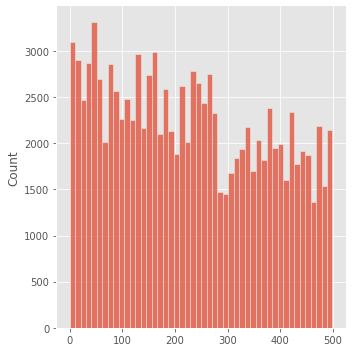

In [107]:
plt.style.use('ggplot')
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 10
sns.displot(kmeans.labels_)
plt.show()

### Creating Bag of Visual Words

In [27]:
def get_bag_of_words(labels, n_des, des_size, N, K):
  data = np.zeros((N, K), dtype='int32')
  for i in range(n_des):
    data[i//des_size, labels[i]]+=1
  return data

In [28]:
train_data = get_bag_of_words(kmeans.labels_, len(train_descriptors), des_size,train_images.shape[0], K)
test_data = get_bag_of_words(kmeans.predict(test_descriptors), len(test_descriptors), des_size,test_images.shape[0], K)
print(train_data.shape, test_data.shape)

(640, 2000) (160, 2000)


In [29]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma='auto'))
clf = SVC(kernel='linear')
clf.fit(train_data, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## With bag of words

### Step_size = 5 and K = 500

Acurracy :  0.6375
[[14  0  3  0  0  1  0  2]
 [ 1 10  1  2  3  0  3  0]
 [ 5  1 11  0  0  1  1  1]
 [ 0  1  0 18  0  0  0  1]
 [ 1  5  1  5  6  0  2  0]
 [ 0  2  0  0  0 15  2  1]
 [ 1  0  0  0  1  5 13  0]
 [ 3  0  2  0  0  0  0 15]]


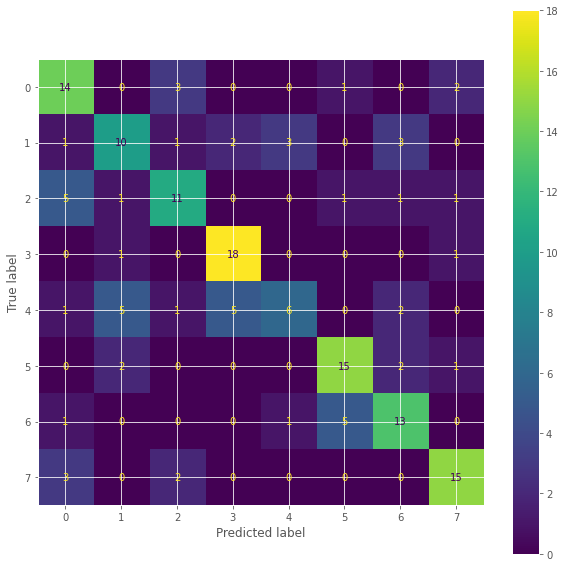

In [95]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
pred_labels = clf.predict(test_data)
print("Acurracy : ", accuracy_score(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))
plt.figure(figsize=(5, 5))
plot_confusion_matrix(clf, test_data, test_labels)  
plt.show()  

In [96]:
from sklearn.svm import SVC, LinearSVC
list_C = [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 5, 10, 50, 100]
for c in list_C:
  clf = LinearSVC(C=c, multi_class='ovr', random_state=0)
  clf.fit(train_data, train_labels)
  pred_labels = clf.predict(test_data)
  print("C = ", c, "  Acurracy : ", accuracy_score(test_labels, pred_labels))

C =  0.01   Acurracy :  0.6375
C =  0.05   Acurracy :  0.64375
C =  0.1   Acurracy :  0.64375
C =  0.5   Acurracy :  0.64375
C =  1.0   Acurracy :  0.64375
C =  1.5   Acurracy :  0.64375
C =  2   Acurracy :  0.64375
C =  5   Acurracy :  0.64375
C =  10   Acurracy :  0.64375
C =  50   Acurracy :  0.64375
C =  100   Acurracy :  0.64375


### Step_size = 10 and K = 500 

Acurracy :  0.61875
[[13  0  4  1  0  0  1  1]
 [ 0 11  1  3  3  0  2  0]
 [ 2  0 12  2  1  1  0  2]
 [ 1  1  0 18  0  0  0  0]
 [ 0  7  1  5  6  0  1  0]
 [ 0  3  1  0  0 12  3  1]
 [ 1  1  0  0  1  4 13  0]
 [ 3  1  1  1  0  0  0 14]]


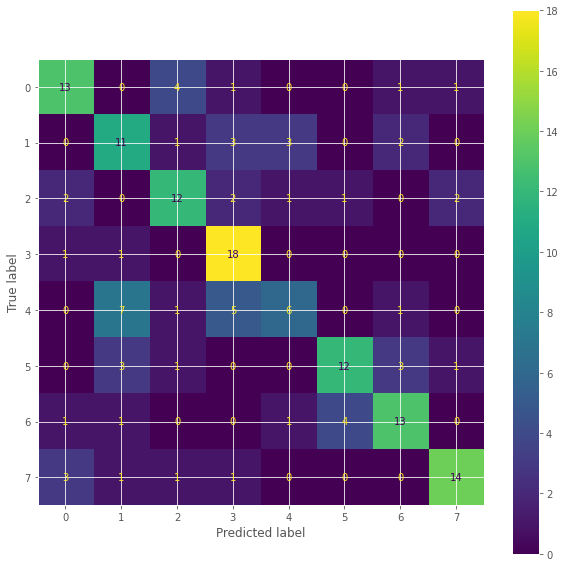

In [111]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
pred_labels = clf.predict(test_data)
print("Acurracy : ", accuracy_score(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))
plt.figure(figsize=(5, 5))
plot_confusion_matrix(clf, test_data, test_labels)  
plt.show()  

In [112]:
from sklearn.svm import SVC, LinearSVC
list_C = [0.01, 0.05, 0.1, 1, 10, 100]
for c in list_C:
  clf = SVC(kernel='linear', random_state=0)
  clf.fit(train_data, train_labels)
  pred_labels = clf.predict(test_data)
  print("C = ", c, "  Acurracy : ", accuracy_score(test_labels, pred_labels))

C =  0.01   Acurracy :  0.61875
C =  0.05   Acurracy :  0.61875
C =  0.1   Acurracy :  0.61875
C =  1   Acurracy :  0.61875
C =  10   Acurracy :  0.61875
C =  100   Acurracy :  0.61875


### Perform TF-IDF on the bag of words to improve accuracy

In [30]:
def fit_transform_tf_idf(data1):
  N = data1.shape[0]
  data2 = data1.copy()
  data2[data1 != 0] = 1
  tf = data1/(np.sum(data1, axis=1).reshape(-1, 1)+1)
  df = np.sum(data2, axis=0)
  idf = np.log((N+1)/(df+1))+1
  tf_idf = np.multiply(tf, idf)
  print(N, tf_idf.shape)
  return tf_idf, idf, N

def transform_tf_idf(data1, idf, N):
  data2 = data1.copy()
  data2[data1 != 0] = 1
  tf = data1/(np.sum(data1, axis=1).reshape(-1, 1)+1)
  tf_idf = np.multiply(tf, idf)
  print(N, tf_idf.shape)
  return tf_idf

### TF-IDF

TF -> Term Frequency

IDF -> Inverse Doccument Frequency

f = frequency of particular word in Bovw img

n = total number of visual words in img

N = total number of images

df = number of images in which a particular visual word is appeared

tf = f/n

idf = log(N/(df+1))



In [31]:
train_data_tf_idf, idf, N = fit_transform_tf_idf(train_data)
# print(idf)
test_data_tf_idf = transform_tf_idf(test_data, idf, N)
print(train_data_tf_idf.shape, test_data_tf_idf.shape)

640 (640, 2000)
640 (160, 2000)
(640, 2000) (160, 2000)


In [32]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma='auto'))
clf = SVC(kernel='linear')
clf.fit(train_data_tf_idf, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## With TF-IDF

### Step_size = 5 and K = 500 

Acurracy :  0.64375
[[12  0  3  1  0  0  1  3]
 [ 1 14  1  1  2  0  1  0]
 [ 6  0 10  0  1  1  1  1]
 [ 0  0  0 19  1  0  0  0]
 [ 0  7  1  5  5  0  2  0]
 [ 1  2  0  0  0 15  2  0]
 [ 0  0  0  0  0  5 15  0]
 [ 2  2  1  2  0  0  0 13]]


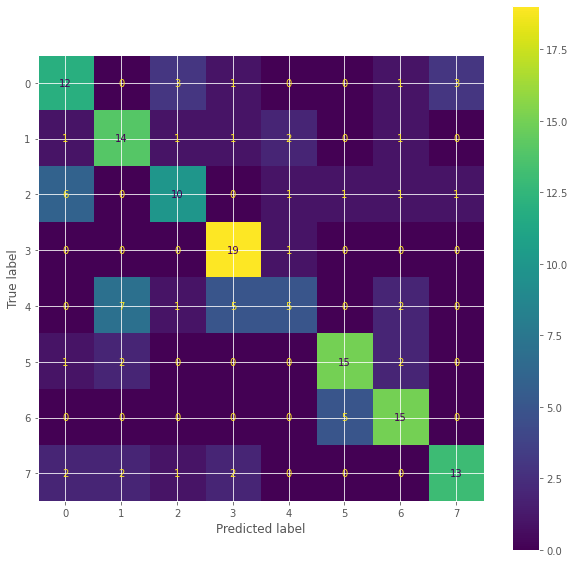

In [100]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
pred_labels = clf.predict(test_data_tf_idf)
print("Acurracy : ", accuracy_score(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))
plt.figure(figsize=(5, 5))
plot_confusion_matrix(clf, test_data_tf_idf, test_labels)  
plt.show()  

In [101]:
from sklearn.svm import SVC, LinearSVC
list_C = [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 5, 10, 50, 100]
for c in list_C:
  clf = LinearSVC(C=c, class_weight=None, dual=True, fit_intercept=True, loss='squared_hinge', max_iter= 2000, multi_class='ovr', penalty='l2', random_state=0)
  clf.fit(train_data_tf_idf, train_labels)
  pred_labels = clf.predict(test_data_tf_idf)
  print("C = ", c, "  Acurracy : ", accuracy_score(test_labels, pred_labels))

C =  0.01   Acurracy :  0.59375
C =  0.05   Acurracy :  0.63125
C =  0.1   Acurracy :  0.65625
C =  0.5   Acurracy :  0.675
C =  1.0   Acurracy :  0.675
C =  1.5   Acurracy :  0.66875
C =  2   Acurracy :  0.68125
C =  5   Acurracy :  0.68125
C =  10   Acurracy :  0.6625
C =  50   Acurracy :  0.6375
C =  100   Acurracy :  0.6375


### Step_size = 10 and K = 500 

Acurracy :  0.63125
[[12  0  5  1  0  0  1  1]
 [ 0 12  1  2  2  0  2  1]
 [ 1  1 12  2  1  1  0  2]
 [ 1  1  0 18  0  0  0  0]
 [ 0  7  1  5  5  0  2  0]
 [ 1  2  1  0  0 12  4  0]
 [ 1  1  0  0  1  3 14  0]
 [ 0  1  1  2  0  0  0 16]]


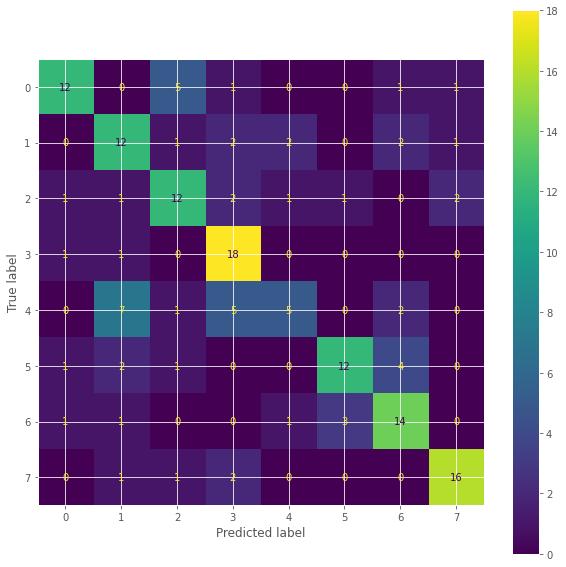

In [116]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
pred_labels = clf.predict(test_data_tf_idf)
print("Acurracy : ", accuracy_score(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))
plt.figure(figsize=(5, 5))
plot_confusion_matrix(clf, test_data_tf_idf, test_labels)  
plt.show()  

In [117]:
from sklearn.svm import SVC, LinearSVC
list_C = [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2, 5, 10, 50, 100]
for c in list_C:
  clf = LinearSVC(C=c, class_weight=None, dual=True, fit_intercept=True, loss='squared_hinge', max_iter= 2000, multi_class='ovr', penalty='l2', random_state=0)
  clf.fit(train_data_tf_idf, train_labels)
  pred_labels = clf.predict(test_data_tf_idf)
  print("C = ", c, "  Acurracy : ", accuracy_score(test_labels, pred_labels))

C =  0.01   Acurracy :  0.59375
C =  0.05   Acurracy :  0.65
C =  0.1   Acurracy :  0.6625
C =  0.5   Acurracy :  0.64375
C =  1.0   Acurracy :  0.625
C =  1.5   Acurracy :  0.61875
C =  2   Acurracy :  0.625
C =  5   Acurracy :  0.63125
C =  10   Acurracy :  0.6125
C =  50   Acurracy :  0.61875
C =  100   Acurracy :  0.6125


Here Step Size = 5

### For K=20

In [ ]:
pred_labels = clf.predict(test_data_tf_idf)
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)

0.43125

### For K=100

In [ ]:
pred_labels = clf.predict(test_data_tf_idf)
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)

0.5625

### For K=100 using mini batch kmeans

In [ ]:
pred_labels = clf.predict(test_data_tf_idf)
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)

0.60625

### For K=500

In [ ]:
pred_labels = clf.predict(test_data_tf_idf)
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labels)

0.66875

### For K=1000

In [ ]:
pred_labels = clf.predict(test_data_tf_idf)
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, pred_labels))

0.6875

### For K=2000

In [36]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma='auto'))
clf = SVC(kernel='linear')
clf.fit(train_data_tf_idf, train_labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [37]:
pred_labels = clf.predict(test_data_tf_idf)
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, pred_labels))

0.70625


In [64]:
import random
randomlist = []
for i in range(0,6):
  n = random.randint(0,160)
  randomlist.append(n)
print(randomlist)

[45, 21, 112, 129, 128, 103]


### Using step size = 5, K=500, C=5

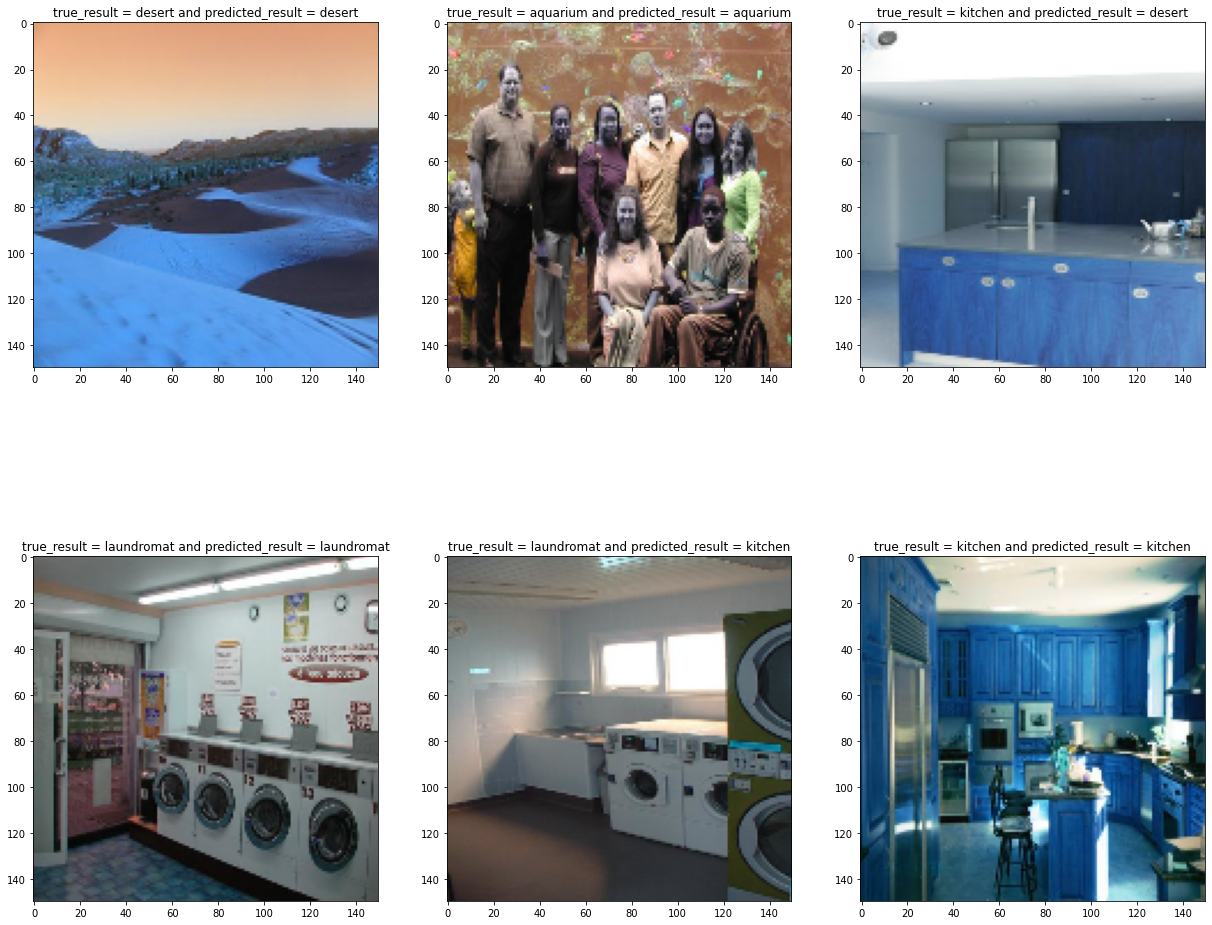

In [73]:
fig=plt.figure(figsize=(21, 18))
c=1
for i in randomlist:
  img = test_images[i]
  true_result = id_to_label(test_labels[i])
  predicted_result = id_to_label(pred_labels[i])
  fig.add_subplot(2, 3, c).set_title("true_result = " + str(true_result) + " and predicted_result = " + str(predicted_result))
  c+=1
  plt.imshow(img)
plt.show()

## Observations: 

  1. By increasing the step size the number of dense sift features decreases. Hence, the accuracy is also decreased.
  2. Best result with step_size = 5
  3. By increasing the K, number of visual words increases, Hence, accuracy is also increased.
  4. Best K = 2000
  5. For C = 0.1 to 5, we get approximately 0.66 accuracy.
  6. Using Tf-Idf the accuracy is increased.
  7. Best result using parameters:
      

```
      step_size = 5;
      K=2000;
      Tf-Idf;
      C=1.0;
      kernel='linear';
```


  
with this, I got
**accuracy = 0.70625**
  


### Spatial Pyramid

#### Train

In [85]:
L=2
K=100
step_size = 5
train_data_spm = []
for i in tqdm(range(len(train_images))):
  img1 = train_images[i].copy()
  w = img1.shape[0]
  h = img1.shape[1]
  data_spm = []
  for l in range(L+1):
    size = 2**l
    w_step = w//size
    h_step = h//size
    x=0
    y=0
    for _ in range(0,size):
      x = 0
      for _ in range(0,size):                
        des = get_descriptors(img1[y:y+h_step, x:x+w_step], step_size)                
        predict = kmeans.predict(des)
        data = np.bincount(predict, minlength=K)
        data = data.reshape(1,-1).ravel()
        weight = 0
        if(l==2):
          weight = 0.5
        else:
          weight = 0.25
        data_spm.append(weight*data)
        x = x + w_step
      y = y + h_step
  data_spm = np.array(data_spm).ravel()
  train_data_spm.append(data_spm)
train_data_spm = np.array(train_data_spm)

#### Test

In [86]:
L=2
K=100
step_size = 5
test_data_spm = []
for i in tqdm(range(len(test_images))):
  img1 = test_images[i].copy()
  w = img1.shape[0]
  h = img1.shape[1]
  data_spm = []
  for l in range(L+1):
    size = 2**l
    w_step = w//size
    h_step = h//size
    x=0
    y=0
    for _ in range(0,size):
      x = 0
      for _ in range(0,size):                
        des = get_descriptors(img1[y:y+h_step, x:x+w_step], step_size)                
        predict = kmeans.predict(des)
        data = np.bincount(predict, minlength=K)
        data = data.reshape(1,-1).ravel()
        weight = 0
        if(l==2):
          weight = 0.5
        else:
          weight = 0.25
        data_spm.append(weight*data)
        x = x + w_step
      y = y + h_step
  data_spm = np.array(data_spm).ravel()
  test_data_spm.append(data_spm)
test_data_spm = np.array(test_data_spm)

In [104]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# clf = make_pipeline(StandardScaler(), SVC(kernel='linear', gamma='auto'))
# clf = SVC(kernel='linear', C=1.0)
clf = LinearSVC(C=0.01, loss='squared_hinge', max_iter= 2000, multi_class='ovr', penalty='l2', random_state=0)
clf.fit(train_data_spm, train_labels)
pred_labels = clf.predict(test_data_spm)
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, pred_labels))

0.6


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [103]:
clf = LinearSVC(C=1, loss='squared_hinge', max_iter= 2000, multi_class='ovr', penalty='l2', random_state=0)
clf.fit(train_data_spm, train_labels)
pred_labels = clf.predict(test_data_spm)
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, pred_labels))

0.59375


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
